# Model

In [10]:
import torch
import torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights
from collections import OrderedDict
import time

class Segmentator(nn.Module):
    def __init__(self):
        super(Segmentator, self).__init__()

        # Initial convolutional layers
        self.initial = nn.Sequential(
            nn.Conv2d(1, 64, 7, 2, 3, bias=False),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2)
        )

        # Load pre-trained ResNet-18 on ImageNet
        weights = ResNet18_Weights.IMAGENET1K_V1
        model = resnet18(weights=weights)

        # Downsampling layers
        self.down1 = nn.Sequential(OrderedDict([('1', model.layer1)]))
        self.down2 = model.layer2

        # Upsampling layers
        self.up1 = nn.Sequential(OrderedDict([
            ('up_conv', nn.ConvTranspose2d(128, 128, 2, 2, 0)),
            ('bn', nn.BatchNorm2d(128)),
            ('relu', nn.ReLU()),
            ('drop', nn.Dropout(0.5))  # Add Dropout
        ]))

        self.up0 = nn.Sequential(OrderedDict([
            ('up_conv', nn.ConvTranspose2d(128, 64, 2, 2, 0)),
            ('bn', nn.BatchNorm2d(64)),
            ('relu', nn.ReLU()),
            ('drop', nn.Dropout(0.5))  # Add Dropout
        ]))

        # Final upsampling and convolutional layers
        self.final_upsample = nn.Sequential(OrderedDict([
            ('1', nn.Conv2d(64, 32, 3, 1, 1, bias=False)),
            ('2', nn.Conv2d(32, 64, 3, 1, 1, bias=False)),
        ]))

        self.final_conv = nn.Conv2d(64, 1, 1, 1, 0)

    def forward(self, x):
        start_time = time.time()  # Record the start time

        print("Input shape:", x.shape)

        x = self.initial(x)
        print("Initial convolution output shape:", x.shape)

        x = self.down1(x)
        print("Downsampling block 1 output shape:", x.shape)

        x = self.down2(x)
        print("Downsampling block 2 output shape:", x.shape)

        x = self.up1(x)
        print("Upsampling block 1 output shape:", x.shape)

        x = self.up0(x)
        print("Upsampling block 2 output shape:", x.shape)

        x = self.final_upsample(x)
        print("Final upsampling output shape:", x.shape)

        x = self.final_conv(x)
        print("Final convolution output shape:", x.shape)

        end_time = time.time()  # Record the end time
        print(f"Total inference time: {end_time - start_time:.4f} seconds")  # Print the total inference time

        return x

# Ckpt

In [11]:
import torch

def read_model_state(data, output_file):
    # Attempt to load the PyTorch model file
    try:
        with open(output_file, 'w', encoding='utf-8') as f:
            f.write(f"Data type: {type(data)}\n")
            
            # If the data is a dictionary, check its keys
            if isinstance(data, dict):
                f.write(f"Dictionary keys: {list(data.keys())}\n")
                
                # If it contains a state_dict, infer the model structure
                if "state_dict" in data or isinstance(data, dict):
                    f.write("This might be the state_dict of a model.\n")
                    # Example: Print part of the state_dict content
                    for key, value in data.items():
                        shape = value.shape if hasattr(value, 'shape') else 'Unknown'
                        f.write(f"Weight name: {key}, Weight shape: {shape}\n")
            else:
                f.write(f"File content: {data}\n")
    except Exception as e:
        with open(output_file, 'a', encoding='utf-8') as f:
            f.write(f"Failed to read the file: {e}\n")

# Example: Read a PyTorch model file
file_path = "segmentator.pkl"
output_path = "model_deepbreath.txt"

# Load the model file
try:
    with open(file_path, 'rb') as f:
        data = torch.load(f, map_location="cpu")
        read_model_state(data, output_path)
    print(f"Output has been saved to: {output_path}")
except Exception as e:
    print(f"Failed to load the model file: {e}")

Output has been saved to: model_deepbreath.txt


C:\Users\LMAPA\AppData\Local\Temp\ipykernel_15236\3785910173.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(f, map_location="cpu")


In [12]:
# Instantiate the model
model = Segmentator()

# Save the model's state_dict to a file for inspection
read_model_state(model.state_dict(), "model_test.txt")

# Load the weights
file_path = "segmentator.pkl"
state_dict = torch.load(file_path, map_location="cpu")
model.load_state_dict(state_dict, strict=True)

print("Model loaded successfully!")

Model loaded successfully!


C:\Users\LMAPA\AppData\Local\Temp\ipykernel_15236\4001040057.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(file_path, map_location="cpu")


# Eval

Processing image: depth00006.png, Original shape: (424, 512)
Input shape: torch.Size([1, 1, 128, 128])
Initial convolution output shape: torch.Size([1, 64, 32, 32])
Downsampling block 1 output shape: torch.Size([1, 64, 32, 32])
Downsampling block 2 output shape: torch.Size([1, 128, 16, 16])
Upsampling block 1 output shape: torch.Size([1, 128, 32, 32])
Upsampling block 2 output shape: torch.Size([1, 64, 64, 64])
Final upsampling output shape: torch.Size([1, 64, 64, 64])
Final convolution output shape: torch.Size([1, 1, 64, 64])
Total inference time: 0.0129 seconds
Input shape: torch.Size([1, 1, 128, 128])
Initial convolution output shape: torch.Size([1, 64, 32, 32])
Downsampling block 1 output shape: torch.Size([1, 64, 32, 32])
Downsampling block 2 output shape: torch.Size([1, 128, 16, 16])
Upsampling block 1 output shape: torch.Size([1, 128, 32, 32])
Upsampling block 2 output shape: torch.Size([1, 64, 64, 64])
Final upsampling output shape: torch.Size([1, 64, 64, 64])
Final convolution

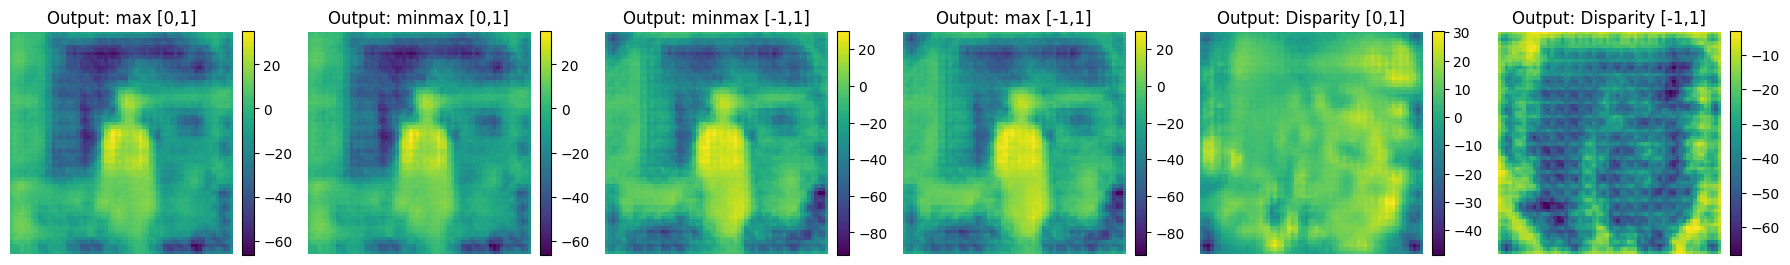

In [13]:
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt

# Set model to evaluation mode
model.eval()

# Paths to data and output folders
data_folder = "data/01"
output_folder = "data/output_masks"
os.makedirs(output_folder, exist_ok=True)

# Get all PNG files in the data folder
png_files = [f for f in os.listdir(data_folder) if f.endswith(".png")]

if len(png_files) == 0:
    print("No PNG files found in the folder.")
else:
    # Read the first PNG file
    file_name = png_files[0]
    file_path = os.path.join(data_folder, file_name)
    depth_map = cv2.imread(file_path, cv2.IMREAD_UNCHANGED)

    if depth_map is None:
        print(f"Unable to load image: {file_path}")
    else:
        print(f"Processing image: {file_name}, Original shape: {depth_map.shape}")

        # Resize the depth map to 128x128
        depth_map_resized = cv2.resize(depth_map, (128, 128), interpolation=cv2.INTER_LINEAR)

        # 1. Normalize by max to [0, 1]
        norm_max_0_1 = depth_map_resized / np.max(depth_map_resized)
        input_max_0_1 = torch.tensor(norm_max_0_1, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

        # 2. Min-max normalize to [0, 1]
        norm_minmax_0_1 = (depth_map_resized - np.min(depth_map_resized)) / (np.max(depth_map_resized) - np.min(depth_map_resized))
        input_minmax_0_1 = torch.tensor(norm_minmax_0_1, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

        # 3. Min-max normalize to [-1, 1]
        norm_minmax_m1_1 = 2 * norm_minmax_0_1 - 1
        input_minmax_m1_1 = torch.tensor(norm_minmax_m1_1, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

        # 4. Normalize by max to [-1, 1]
        norm_max_m1_1 = 2 * (depth_map_resized / np.max(depth_map_resized)) - 1
        input_max_m1_1 = torch.tensor(norm_max_m1_1, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

        # 5. Disparity normalize to [0, 1]
        disparity_map = 1.0 / (depth_map_resized + 1e-6)
        norm_disp_0_1 = (disparity_map - np.min(disparity_map)) / (np.max(disparity_map) - np.min(disparity_map))
        input_disp_0_1 = torch.tensor(norm_disp_0_1, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

        # 6. Disparity normalize to [-1, 1]
        norm_disp_m1_1 = 2 * norm_disp_0_1 - 1
        input_disp_m1_1 = torch.tensor(norm_disp_m1_1, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

        # Pass each normalized input through the model and collect outputs
        with torch.no_grad():
            out_max_0_1 = model(input_max_0_1).squeeze().numpy()
            out_minmax_0_1 = model(input_minmax_0_1).squeeze().numpy()
            out_minmax_m1_1 = model(input_minmax_m1_1).squeeze().numpy()
            out_max_m1_1 = model(input_max_m1_1).squeeze().numpy()
            out_disp_0_1 = model(input_disp_0_1).squeeze().numpy()
            out_disp_m1_1 = model(input_disp_m1_1).squeeze().numpy()

        # Plot only the outputs
        plt.figure(figsize=(18, 4))
        plt.subplot(1, 6, 1)
        plt.title("Output: max [0,1]")
        plt.imshow(out_max_0_1, cmap="viridis")
        plt.colorbar(fraction=0.046, pad=0.04)
        plt.axis("off")

        plt.subplot(1, 6, 2)
        plt.title("Output: minmax [0,1]")
        plt.imshow(out_minmax_0_1, cmap="viridis")
        plt.colorbar(fraction=0.046, pad=0.04)
        plt.axis("off")

        plt.subplot(1, 6, 3)
        plt.title("Output: minmax [-1,1]")
        plt.imshow(out_minmax_m1_1, cmap="viridis")
        plt.colorbar(fraction=0.046, pad=0.04)
        plt.axis("off")

        plt.subplot(1, 6, 4)
        plt.title("Output: max [-1,1]")
        plt.imshow(out_max_m1_1, cmap="viridis")
        plt.colorbar(fraction=0.046, pad=0.04)
        plt.axis("off")

        plt.subplot(1, 6, 5)
        plt.title("Output: Disparity [0,1]")
        plt.imshow(out_disp_0_1, cmap="viridis")
        plt.colorbar(fraction=0.046, pad=0.04)
        plt.axis("off")

        plt.subplot(1, 6, 6)
        plt.title("Output: Disparity [-1,1]")
        plt.imshow(out_disp_m1_1, cmap="viridis")
        plt.colorbar(fraction=0.046, pad=0.04)
        plt.axis("off")

        plt.tight_layout()
        plt.show()

## It shows that using [min, max] to normalize the data into [-1, 1] gives the best result.

Processing image: depth00006.png, Original shape: (424, 512)
Input shape: torch.Size([1, 1, 128, 128])
Initial convolution output shape: torch.Size([1, 64, 32, 32])
Downsampling block 1 output shape: torch.Size([1, 64, 32, 32])
Downsampling block 2 output shape: torch.Size([1, 128, 16, 16])
Upsampling block 1 output shape: torch.Size([1, 128, 32, 32])
Upsampling block 2 output shape: torch.Size([1, 64, 64, 64])
Final upsampling output shape: torch.Size([1, 64, 64, 64])
Final convolution output shape: torch.Size([1, 1, 64, 64])
Total inference time: 0.0138 seconds


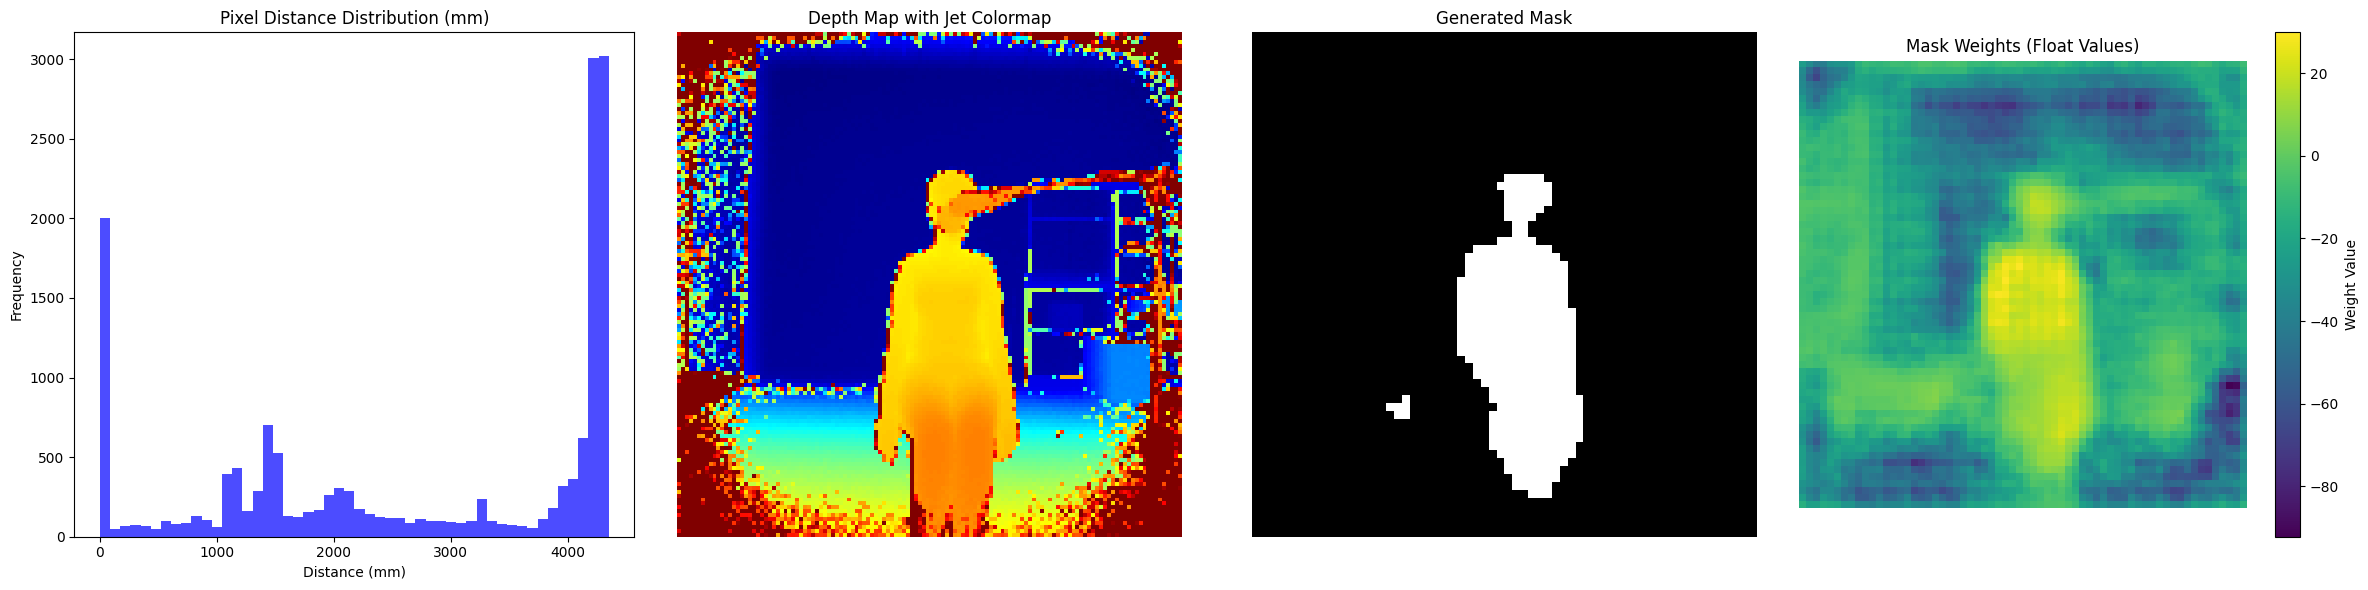

Processing image: depth00011.png, Original shape: (424, 512)
Input shape: torch.Size([1, 1, 128, 128])
Initial convolution output shape: torch.Size([1, 64, 32, 32])
Downsampling block 1 output shape: torch.Size([1, 64, 32, 32])
Downsampling block 2 output shape: torch.Size([1, 128, 16, 16])
Upsampling block 1 output shape: torch.Size([1, 128, 32, 32])
Upsampling block 2 output shape: torch.Size([1, 64, 64, 64])
Final upsampling output shape: torch.Size([1, 64, 64, 64])
Final convolution output shape: torch.Size([1, 1, 64, 64])
Total inference time: 0.0178 seconds


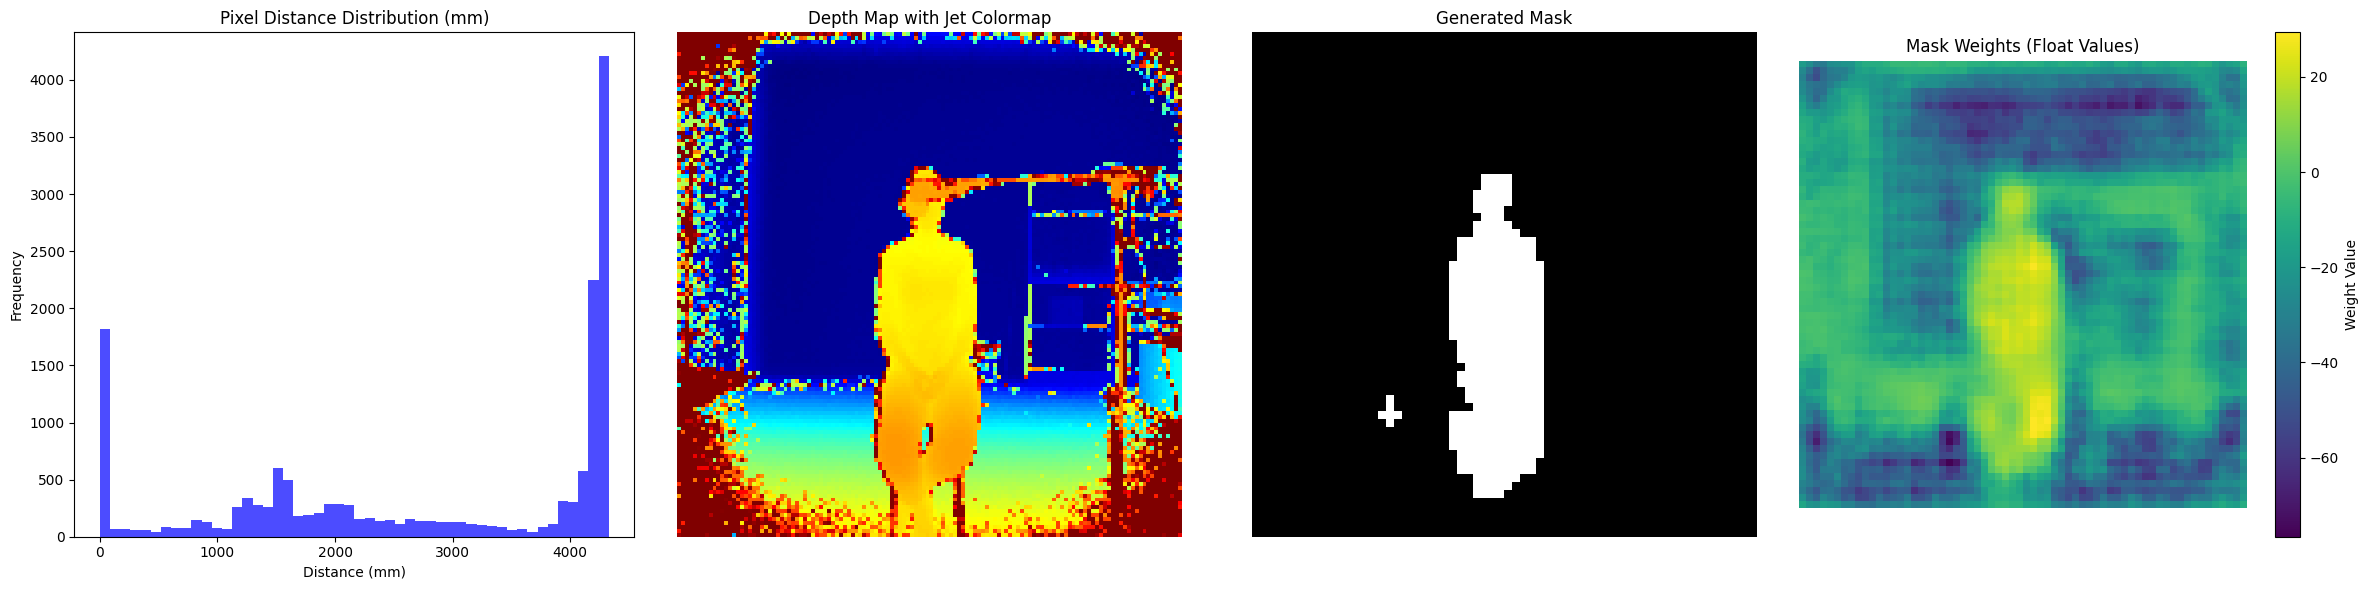

Processing image: depth00014.png, Original shape: (424, 512)
Input shape: torch.Size([1, 1, 128, 128])
Initial convolution output shape: torch.Size([1, 64, 32, 32])
Downsampling block 1 output shape: torch.Size([1, 64, 32, 32])
Downsampling block 2 output shape: torch.Size([1, 128, 16, 16])
Upsampling block 1 output shape: torch.Size([1, 128, 32, 32])
Upsampling block 2 output shape: torch.Size([1, 64, 64, 64])
Final upsampling output shape: torch.Size([1, 64, 64, 64])
Final convolution output shape: torch.Size([1, 1, 64, 64])
Total inference time: 0.0123 seconds


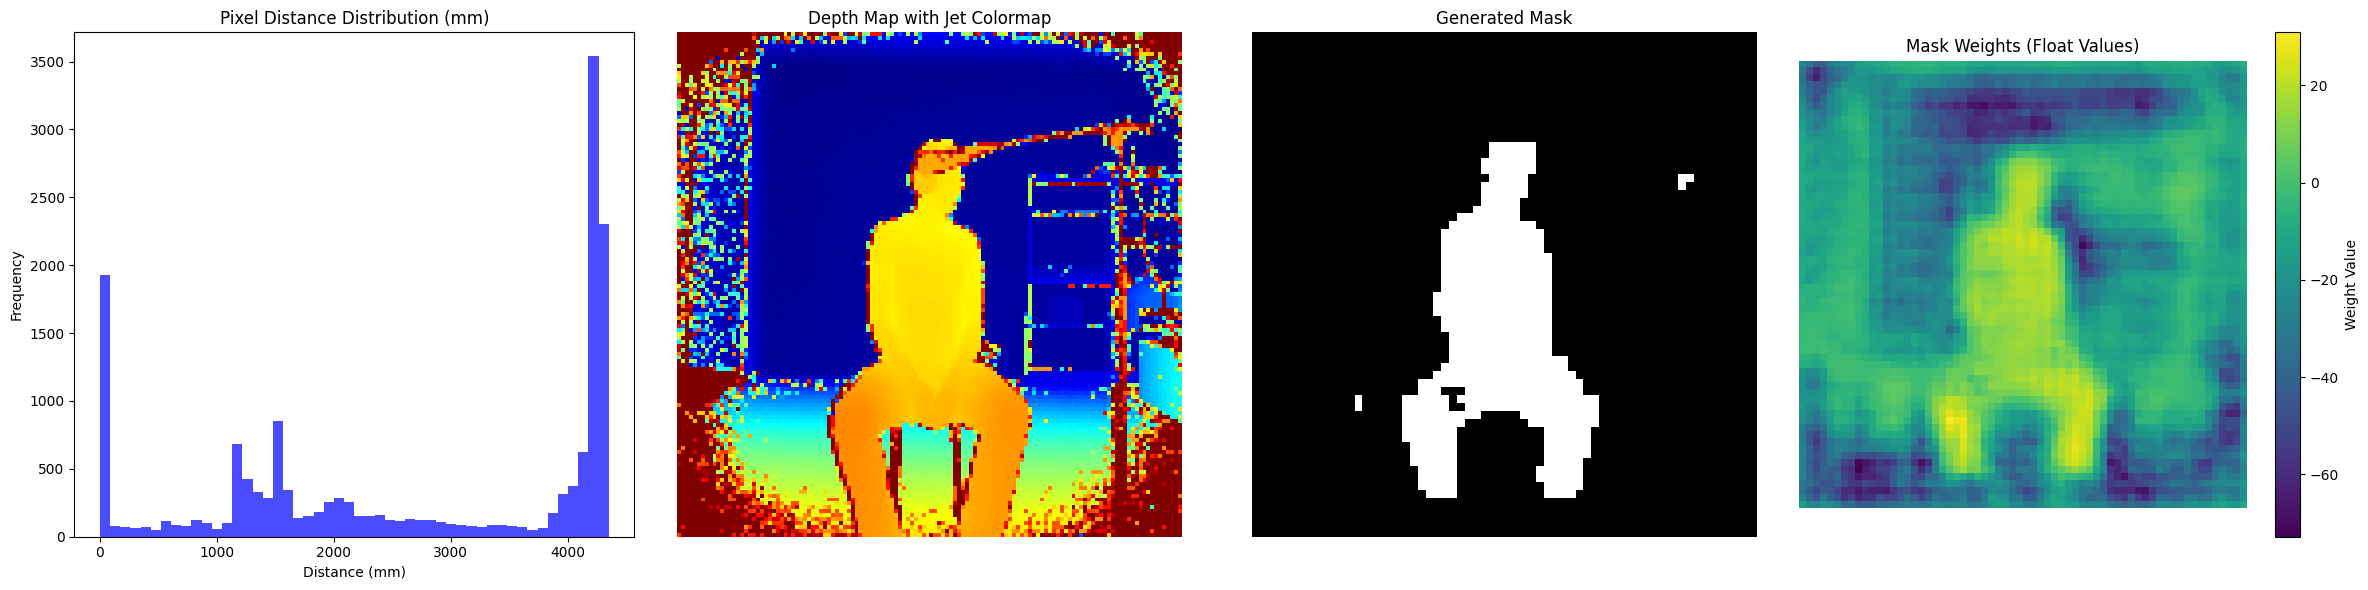

Processing image: depth00022.png, Original shape: (424, 512)
Input shape: torch.Size([1, 1, 128, 128])
Initial convolution output shape: torch.Size([1, 64, 32, 32])
Downsampling block 1 output shape: torch.Size([1, 64, 32, 32])
Downsampling block 2 output shape: torch.Size([1, 128, 16, 16])
Upsampling block 1 output shape: torch.Size([1, 128, 32, 32])
Upsampling block 2 output shape: torch.Size([1, 64, 64, 64])
Final upsampling output shape: torch.Size([1, 64, 64, 64])
Final convolution output shape: torch.Size([1, 1, 64, 64])
Total inference time: 0.0174 seconds


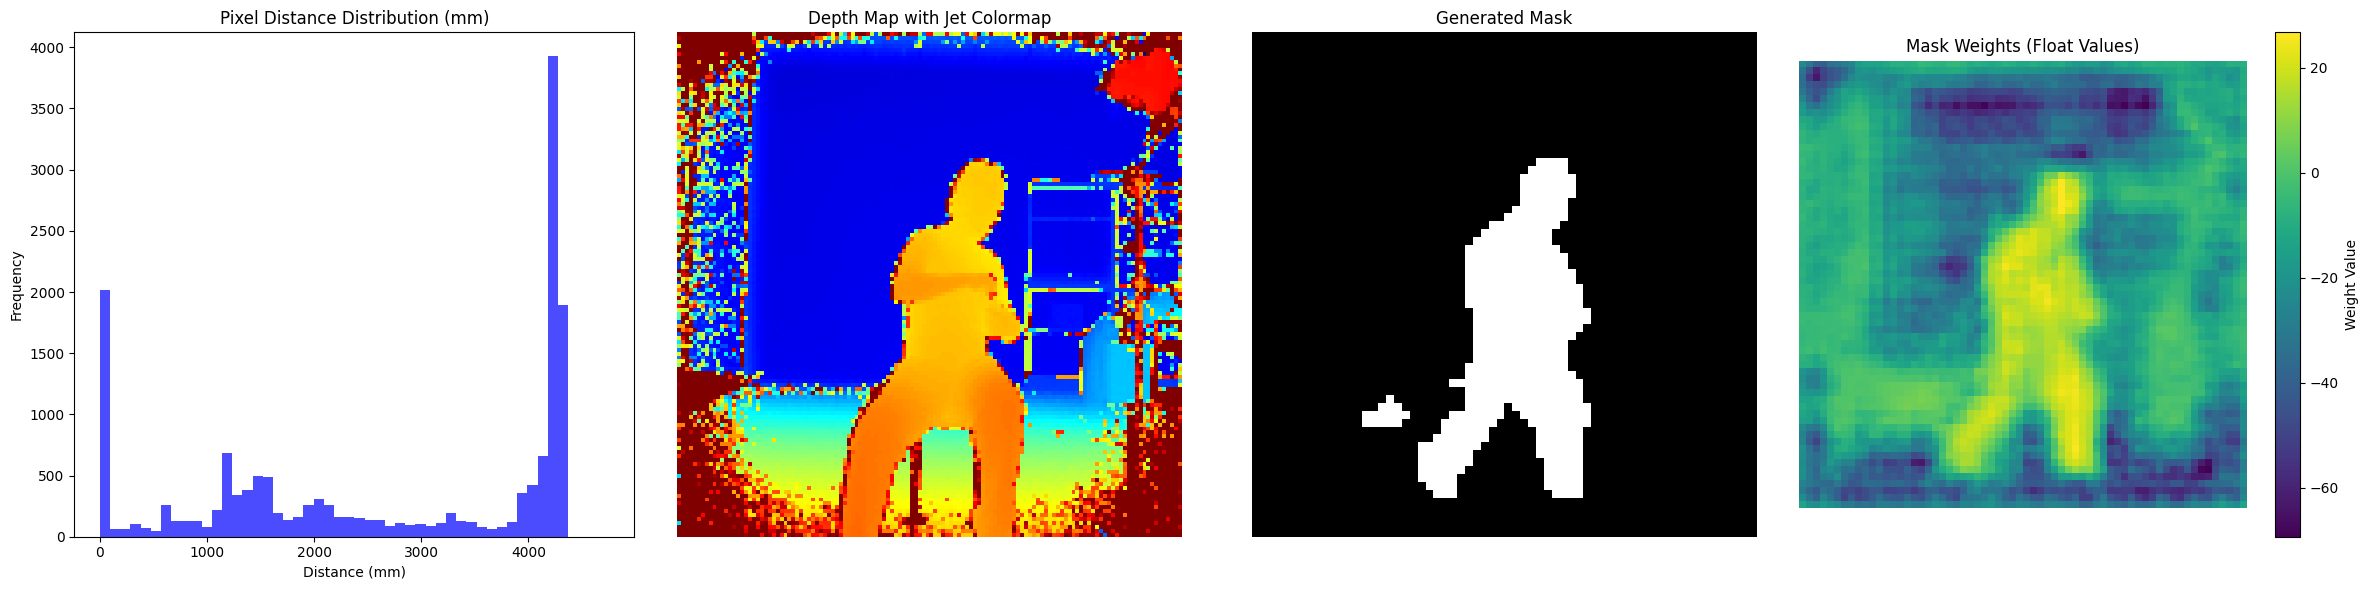

In [14]:
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt

# Load the model
model.eval()  # Set the model to evaluation mode

# Paths to data and output folders
data_folder = "data/01"
output_folder = "data/output_masks"
os.makedirs(output_folder, exist_ok=True)  # Create the output folder if it doesn't exist

# Get all PNG files in the data folder
png_files = [f for f in os.listdir(data_folder) if f.endswith(".png")]

# Process each PNG file
for file_name in png_files:
    file_path = os.path.join(data_folder, file_name)
    depth_map = cv2.imread(file_path, cv2.IMREAD_UNCHANGED)  # Load as a grayscale image (single channel)

    if depth_map is None:
        print(f"Unable to load image: {file_path}")
        continue

    print(f"Processing image: {file_name}, Original shape: {depth_map.shape}")

    # Resize the depth map to 128x128
    depth_map = cv2.resize(depth_map, (128, 128), interpolation=cv2.INTER_LINEAR)

    # Normalize the depth map to [0, 1]
    # normalized_depth_map = depth_map / np.max(depth_map)
    # Normalize the depth map to [-1, 1]
    normalized_depth_map = 2 * (depth_map - np.min(depth_map)) / (np.max(depth_map) - np.min(depth_map)) - 1

    input_tensor = torch.tensor(normalized_depth_map, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

    # Pass the tensor through the model
    with torch.no_grad():  # Disable gradient computation
        output = model(input_tensor)
        output_np = output.squeeze().numpy()

    # Binarize the output to create a mask (values 0 or 1)
    threshold = 5.0  # Set the threshold
    binary_mask = (output_np > threshold).astype(np.uint8)  # Values greater than the threshold are set to 1, others to 0

    # Convert the binary mask to an image format
    output_image = (binary_mask * 255).astype(np.uint8)  # Convert 0 and 1 to 0 and 255

    # Save the mask image
    output_file_path = os.path.join(output_folder, f"mask_{file_name}")
    cv2.imwrite(output_file_path, output_image)

    # Visualize the depth map using a jet colormap
    depth_colored = cv2.applyColorMap(cv2.convertScaleAbs(depth_map, alpha=255 / np.max(depth_map)), cv2.COLORMAP_JET)

    # Visualize the original depth map, mask, and pixel distribution
    plt.figure(figsize=(24, 6))

    # Subplot 1: Pixel distance distribution
    plt.subplot(1, 4, 1)
    plt.title("Pixel Distance Distribution (mm)")
    plt.hist(depth_map.flatten(), bins=50, color='blue', alpha=0.7)
    plt.xlabel("Distance (mm)")
    plt.ylabel("Frequency")

    # Subplot 2: Depth map with jet colormap
    plt.subplot(1, 4, 2)
    plt.title("Depth Map with Jet Colormap")
    plt.imshow(depth_colored)
    plt.axis("off")

    # Subplot 3: Generated mask
    plt.subplot(1, 4, 3)
    plt.title("Generated Mask")
    plt.imshow(output_image, cmap="gray")
    plt.axis("off")

    # Subplot 4: Mask weights (float values)
    plt.subplot(1, 4, 4)
    plt.title("Mask Weights (Float Values)")
    plt.imshow(output_np, cmap="viridis")  # Use Viridis colormap to display float weights
    plt.colorbar(label="Weight Value")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

Processing image: depth_frame_123.png, Original shape: (480, 640)
Input shape: torch.Size([1, 1, 128, 128])
Initial convolution output shape: torch.Size([1, 64, 32, 32])
Downsampling block 1 output shape: torch.Size([1, 64, 32, 32])
Downsampling block 2 output shape: torch.Size([1, 128, 16, 16])
Upsampling block 1 output shape: torch.Size([1, 128, 32, 32])
Upsampling block 2 output shape: torch.Size([1, 64, 64, 64])
Final upsampling output shape: torch.Size([1, 64, 64, 64])
Final convolution output shape: torch.Size([1, 1, 64, 64])
Total inference time: 0.0147 seconds
Input shape: torch.Size([1, 1, 128, 128])
Initial convolution output shape: torch.Size([1, 64, 32, 32])
Downsampling block 1 output shape: torch.Size([1, 64, 32, 32])
Downsampling block 2 output shape: torch.Size([1, 128, 16, 16])
Upsampling block 1 output shape: torch.Size([1, 128, 32, 32])
Upsampling block 2 output shape: torch.Size([1, 64, 64, 64])
Final upsampling output shape: torch.Size([1, 64, 64, 64])
Final convol

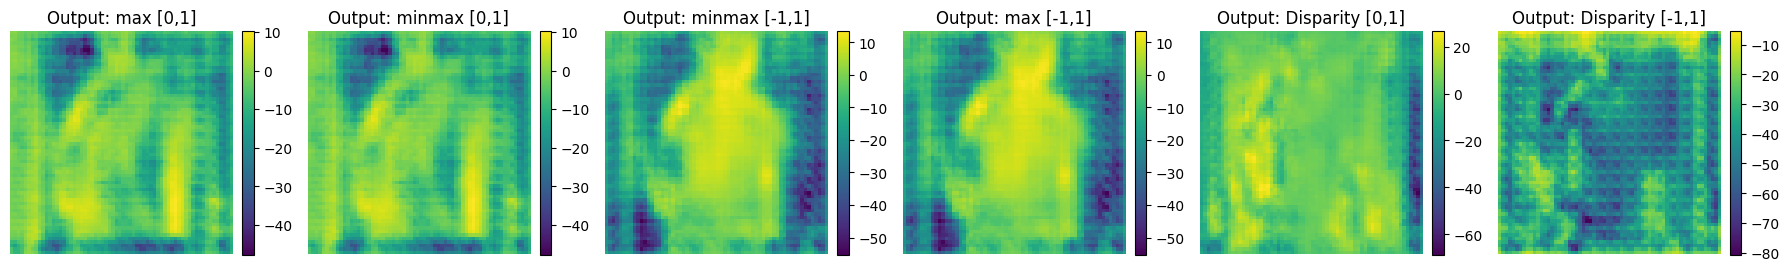

In [15]:
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt

# Set model to evaluation mode
model.eval()

# Paths to data and output folders
data_folder = "data/02"
output_folder = "data/output_masks"
os.makedirs(output_folder, exist_ok=True)

# Get all PNG files in the data folder
png_files = [f for f in os.listdir(data_folder) if f.endswith(".png")]

if len(png_files) == 0:
    print("No PNG files found in the folder.")
else:
    # Read the first PNG file
    file_name = png_files[0]
    file_path = os.path.join(data_folder, file_name)
    depth_map = cv2.imread(file_path, cv2.IMREAD_UNCHANGED)

    if depth_map is None:
        print(f"Unable to load image: {file_path}")
    else:
        print(f"Processing image: {file_name}, Original shape: {depth_map.shape}")

        # Resize the depth map to 128x128
        depth_map_resized = cv2.resize(depth_map, (128, 128), interpolation=cv2.INTER_LINEAR)

        # Remove large values
        depth_map_resized[depth_map_resized > 3000] = 3000

        # 1. Normalize by max to [0, 1]
        norm_max_0_1 = depth_map_resized / np.max(depth_map_resized)
        input_max_0_1 = torch.tensor(norm_max_0_1, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

        # 2. Min-max normalize to [0, 1]
        norm_minmax_0_1 = (depth_map_resized - np.min(depth_map_resized)) / (np.max(depth_map_resized) - np.min(depth_map_resized))
        input_minmax_0_1 = torch.tensor(norm_minmax_0_1, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

        # 3. Min-max normalize to [-1, 1]
        norm_minmax_m1_1 = 2 * norm_minmax_0_1 - 1
        input_minmax_m1_1 = torch.tensor(norm_minmax_m1_1, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

        # 4. Normalize by max to [-1, 1]
        norm_max_m1_1 = 2 * (depth_map_resized / np.max(depth_map_resized)) - 1
        input_max_m1_1 = torch.tensor(norm_max_m1_1, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

        # 5. Disparity normalize to [0, 1]
        disparity_map = 1.0 / (depth_map_resized + 1e-6)
        norm_disp_0_1 = (disparity_map - np.min(disparity_map)) / (np.max(disparity_map) - np.min(disparity_map))
        input_disp_0_1 = torch.tensor(norm_disp_0_1, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

        # 6. Disparity normalize to [-1, 1]
        norm_disp_m1_1 = 2 * norm_disp_0_1 - 1
        input_disp_m1_1 = torch.tensor(norm_disp_m1_1, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

        # Pass each normalized input through the model and collect outputs
        with torch.no_grad():
            out_max_0_1 = model(input_max_0_1).squeeze().numpy()
            out_minmax_0_1 = model(input_minmax_0_1).squeeze().numpy()
            out_minmax_m1_1 = model(input_minmax_m1_1).squeeze().numpy()
            out_max_m1_1 = model(input_max_m1_1).squeeze().numpy()
            out_disp_0_1 = model(input_disp_0_1).squeeze().numpy()
            out_disp_m1_1 = model(input_disp_m1_1).squeeze().numpy()

        # Plot only the outputs
        plt.figure(figsize=(18, 4))
        plt.subplot(1, 6, 1)
        plt.title("Output: max [0,1]")
        plt.imshow(out_max_0_1, cmap="viridis")
        plt.colorbar(fraction=0.046, pad=0.04)
        plt.axis("off")

        plt.subplot(1, 6, 2)
        plt.title("Output: minmax [0,1]")
        plt.imshow(out_minmax_0_1, cmap="viridis")
        plt.colorbar(fraction=0.046, pad=0.04)
        plt.axis("off")

        plt.subplot(1, 6, 3)
        plt.title("Output: minmax [-1,1]")
        plt.imshow(out_minmax_m1_1, cmap="viridis")
        plt.colorbar(fraction=0.046, pad=0.04)
        plt.axis("off")

        plt.subplot(1, 6, 4)
        plt.title("Output: max [-1,1]")
        plt.imshow(out_max_m1_1, cmap="viridis")
        plt.colorbar(fraction=0.046, pad=0.04)
        plt.axis("off")

        plt.subplot(1, 6, 5)
        plt.title("Output: Disparity [0,1]")
        plt.imshow(out_disp_0_1, cmap="viridis")
        plt.colorbar(fraction=0.046, pad=0.04)
        plt.axis("off")

        plt.subplot(1, 6, 6)
        plt.title("Output: Disparity [-1,1]")
        plt.imshow(out_disp_m1_1, cmap="viridis")
        plt.colorbar(fraction=0.046, pad=0.04)
        plt.axis("off")

        plt.tight_layout()
        plt.show()

Processing image: depth_frame_123.png, Original shape: (480, 640)
Input shape: torch.Size([1, 1, 128, 128])
Initial convolution output shape: torch.Size([1, 64, 32, 32])
Downsampling block 1 output shape: torch.Size([1, 64, 32, 32])
Downsampling block 2 output shape: torch.Size([1, 128, 16, 16])
Upsampling block 1 output shape: torch.Size([1, 128, 32, 32])
Upsampling block 2 output shape: torch.Size([1, 64, 64, 64])
Final upsampling output shape: torch.Size([1, 64, 64, 64])
Final convolution output shape: torch.Size([1, 1, 64, 64])
Total inference time: 0.0110 seconds


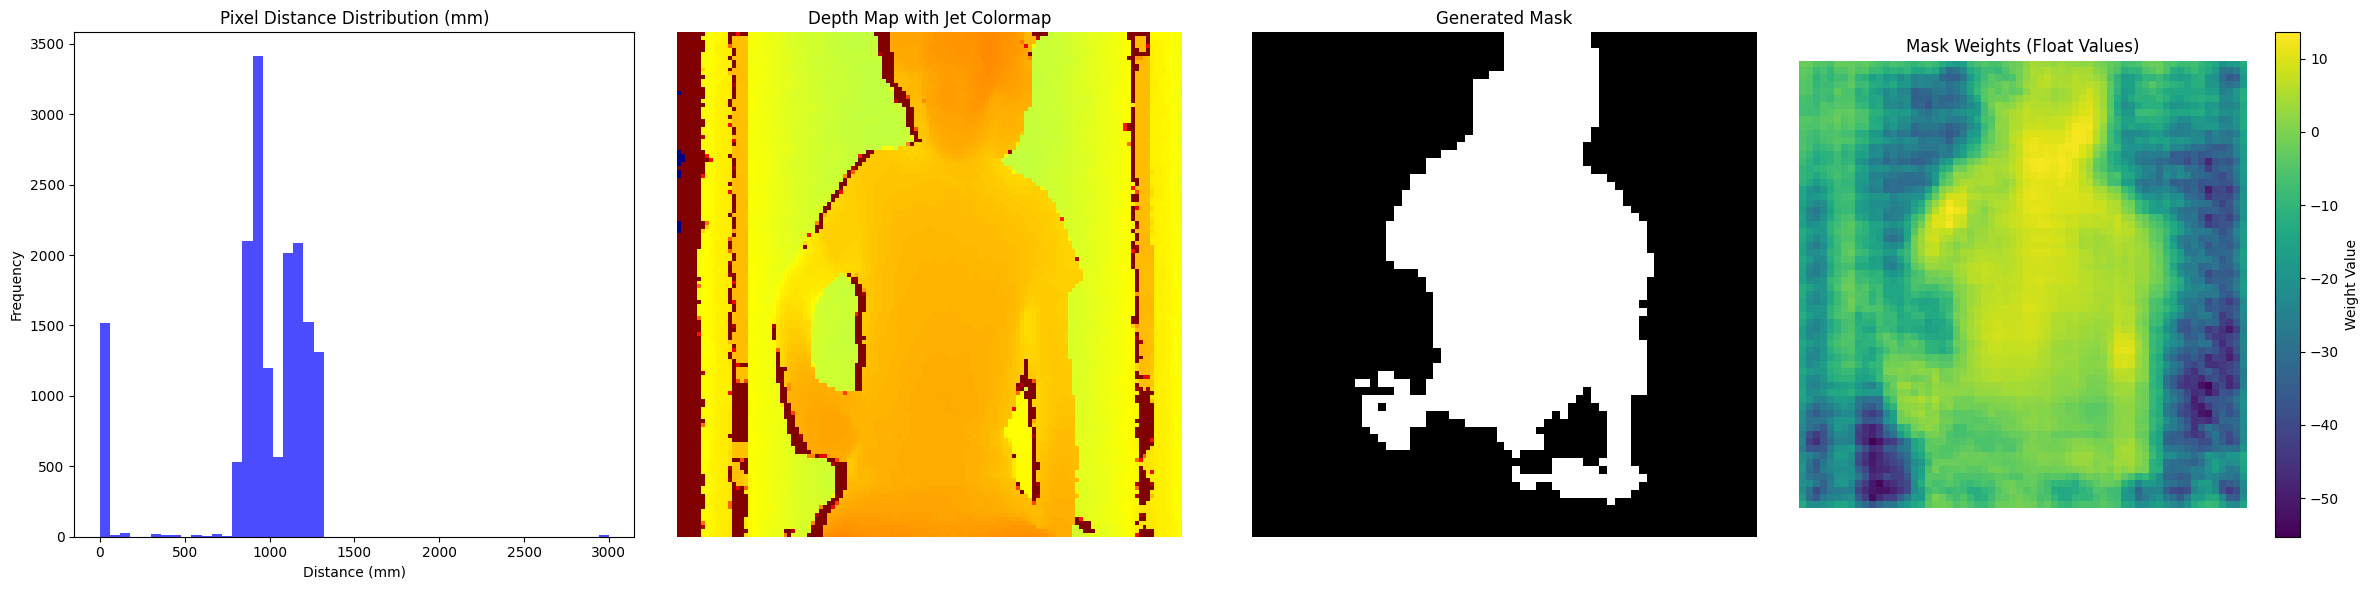

Processing image: depth_frame_1664.png, Original shape: (480, 640)
Input shape: torch.Size([1, 1, 128, 128])
Initial convolution output shape: torch.Size([1, 64, 32, 32])
Downsampling block 1 output shape: torch.Size([1, 64, 32, 32])
Downsampling block 2 output shape: torch.Size([1, 128, 16, 16])
Upsampling block 1 output shape: torch.Size([1, 128, 32, 32])
Upsampling block 2 output shape: torch.Size([1, 64, 64, 64])
Final upsampling output shape: torch.Size([1, 64, 64, 64])
Final convolution output shape: torch.Size([1, 1, 64, 64])
Total inference time: 0.0142 seconds


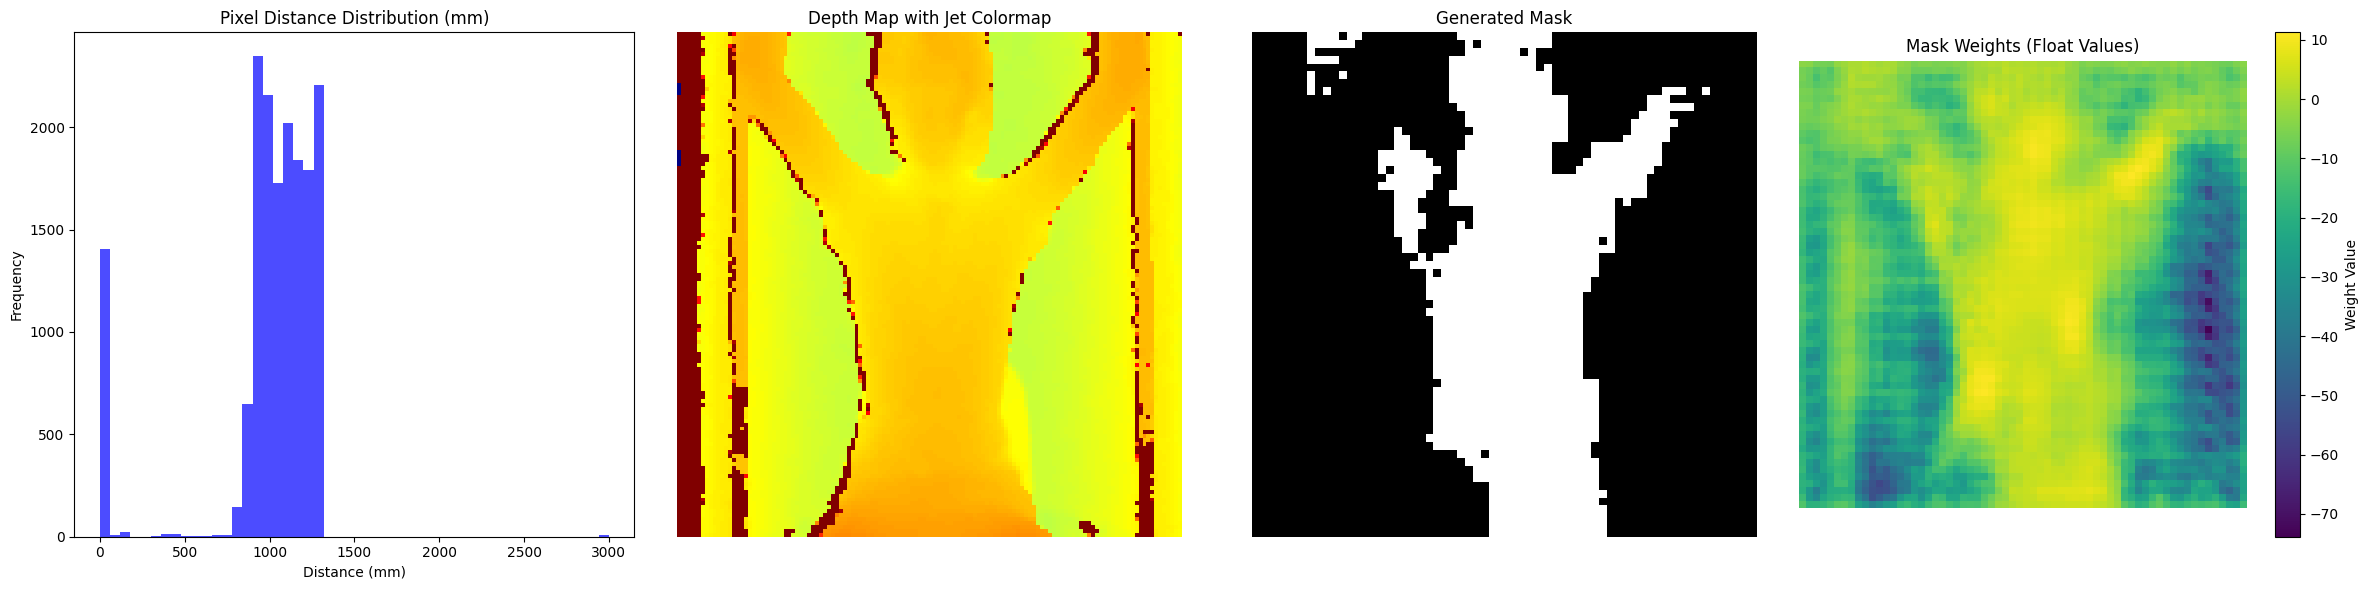

Processing image: depth_frame_234.png, Original shape: (480, 640)
Input shape: torch.Size([1, 1, 128, 128])
Initial convolution output shape: torch.Size([1, 64, 32, 32])
Downsampling block 1 output shape: torch.Size([1, 64, 32, 32])
Downsampling block 2 output shape: torch.Size([1, 128, 16, 16])
Upsampling block 1 output shape: torch.Size([1, 128, 32, 32])
Upsampling block 2 output shape: torch.Size([1, 64, 64, 64])
Final upsampling output shape: torch.Size([1, 64, 64, 64])
Final convolution output shape: torch.Size([1, 1, 64, 64])
Total inference time: 0.0178 seconds


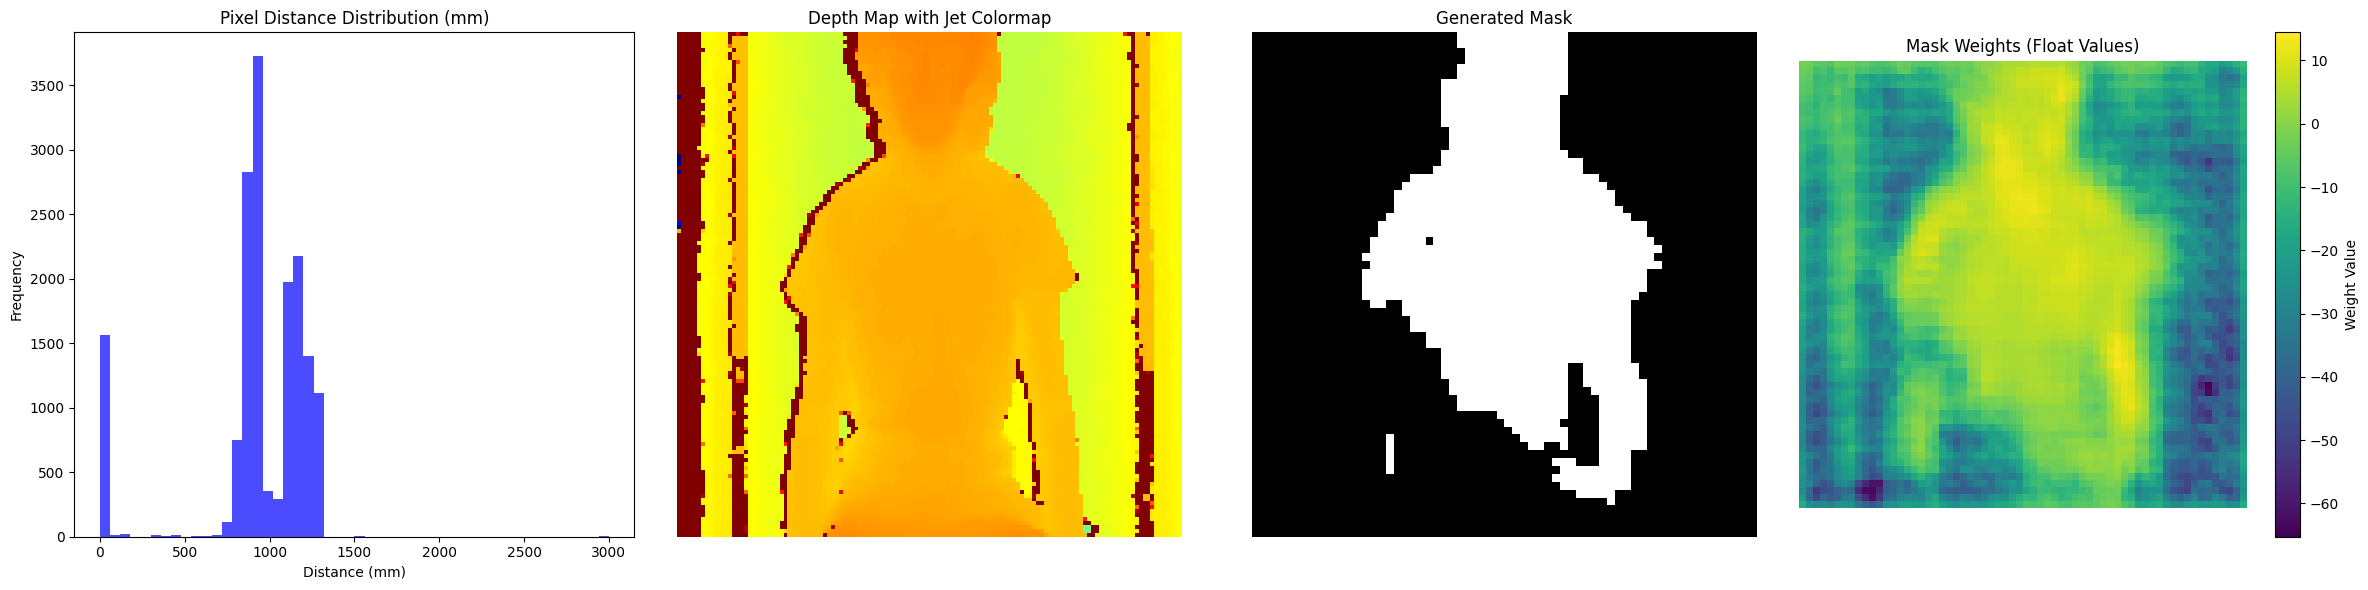

Processing image: depth_frame_567.png, Original shape: (480, 640)
Input shape: torch.Size([1, 1, 128, 128])
Initial convolution output shape: torch.Size([1, 64, 32, 32])
Downsampling block 1 output shape: torch.Size([1, 64, 32, 32])
Downsampling block 2 output shape: torch.Size([1, 128, 16, 16])
Upsampling block 1 output shape: torch.Size([1, 128, 32, 32])
Upsampling block 2 output shape: torch.Size([1, 64, 64, 64])
Final upsampling output shape: torch.Size([1, 64, 64, 64])
Final convolution output shape: torch.Size([1, 1, 64, 64])
Total inference time: 0.0137 seconds


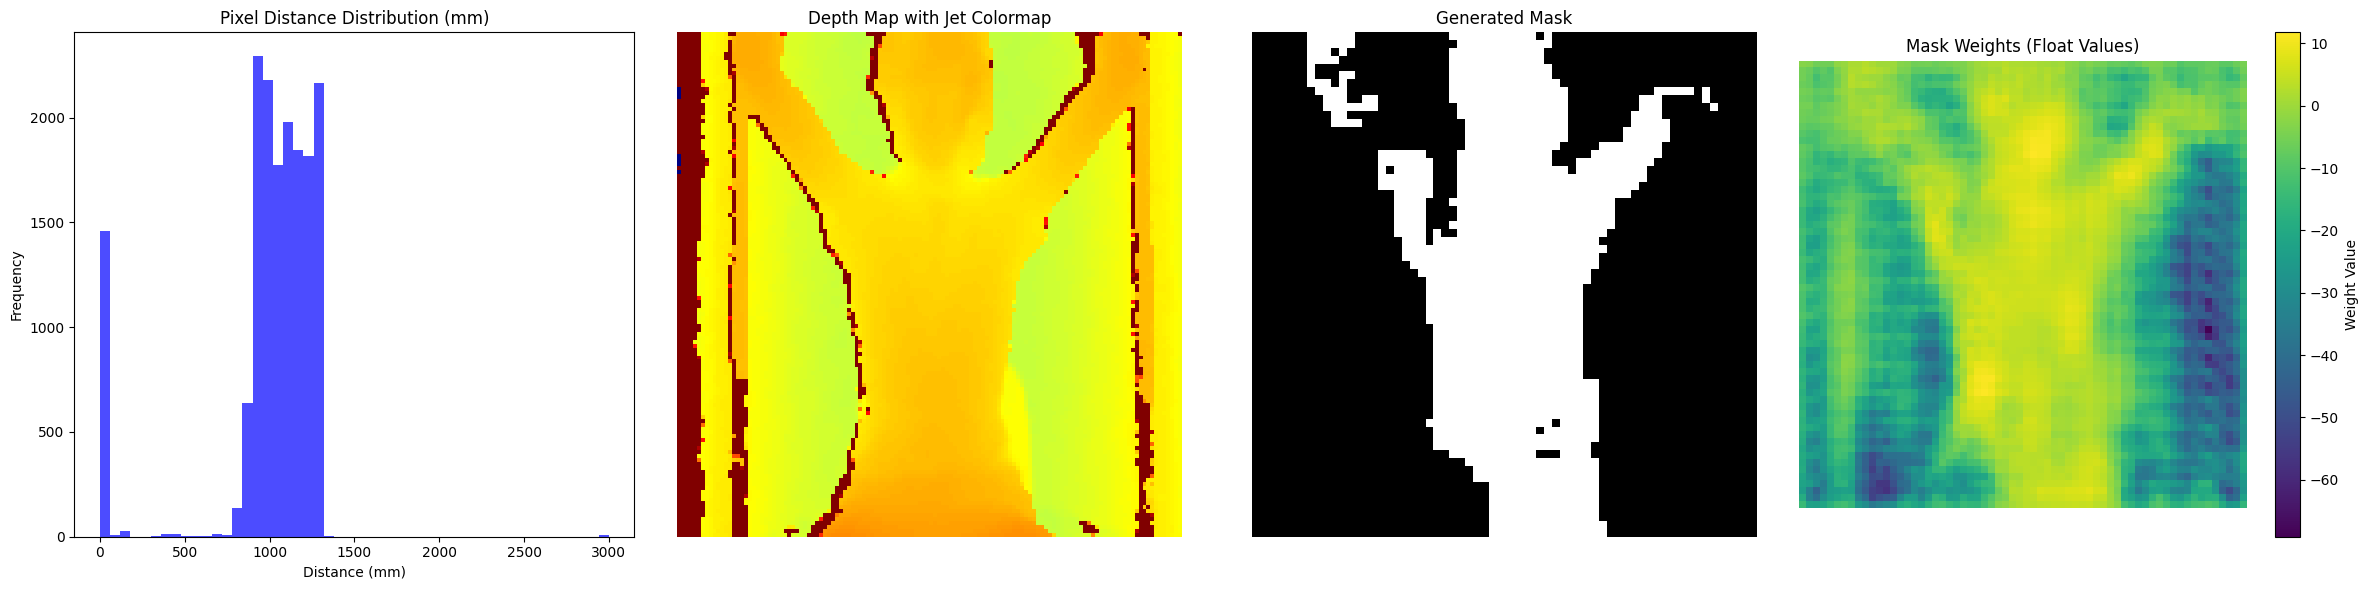

Processing image: depth_frame_678.png, Original shape: (480, 640)
Input shape: torch.Size([1, 1, 128, 128])
Initial convolution output shape: torch.Size([1, 64, 32, 32])
Downsampling block 1 output shape: torch.Size([1, 64, 32, 32])
Downsampling block 2 output shape: torch.Size([1, 128, 16, 16])
Upsampling block 1 output shape: torch.Size([1, 128, 32, 32])
Upsampling block 2 output shape: torch.Size([1, 64, 64, 64])
Final upsampling output shape: torch.Size([1, 64, 64, 64])
Final convolution output shape: torch.Size([1, 1, 64, 64])
Total inference time: 0.0113 seconds


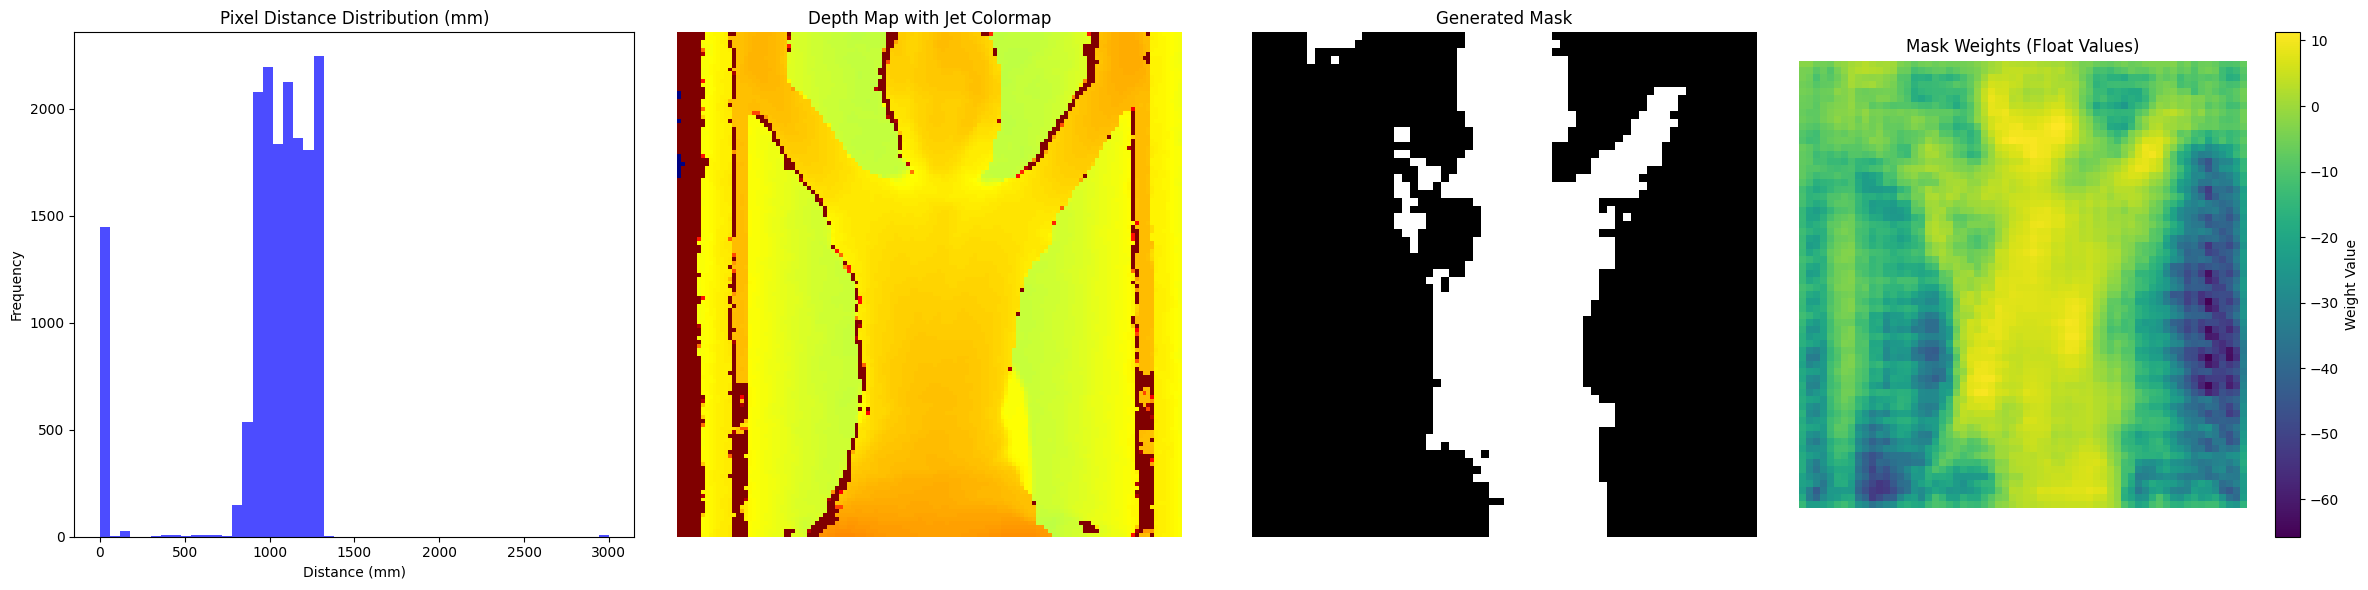

In [16]:
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt

# Load the model
model.eval()  # Set the model to evaluation mode

# Paths to data and output folders
data_folder = "data/02"
output_folder = "data/output_masks"
os.makedirs(output_folder, exist_ok=True)  # Create the output folder if it doesn't exist

# Get all PNG files in the data folder
png_files = [f for f in os.listdir(data_folder) if f.endswith(".png")]

# Process each PNG file
for file_name in png_files:
    file_path = os.path.join(data_folder, file_name)
    depth_map = cv2.imread(file_path, cv2.IMREAD_UNCHANGED)  # Load as a grayscale image (single channel)

    if depth_map is None:
        print(f"Unable to load image: {file_path}")
        continue

    print(f"Processing image: {file_name}, Original shape: {depth_map.shape}")

    # Resize the depth map to 128x128
    depth_map = cv2.resize(depth_map, (128, 128), interpolation=cv2.INTER_LINEAR)

    # Remove large values
    depth_map[depth_map > 3000] = 3000

    # Normalize the depth map to [0, 1]
    # normalized_depth_map = depth_map / np.max(depth_map)
    # normalized_depth_map = (depth_map - np.min(depth_map)) / (np.max(depth_map) - np.min(depth_map))
    # Normalize the depth map to [-1, 1]
    # normalized_depth_map = 2 * depth_map / np.max(depth_map) - 1 
    normalized_depth_map = 2 * (depth_map - np.min(depth_map)) / (np.max(depth_map) - np.min(depth_map)) - 1
    # Normalize the disparity map to [-1, 1]
    # disparity_map = 1.0 / (depth_map + 1e-6)  # Avoid division by zero
    # normalized_depth_map = 2 * (disparity_map - np.min(disparity_map)) / (np.max(disparity_map) - np.min(disparity_map)) - 1
    # normalized_depth_map = (disparity_map - np.min(disparity_map)) / (np.max(disparity_map) - np.min(disparity_map))

    input_tensor = torch.tensor(normalized_depth_map, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

    # Pass the tensor through the model
    with torch.no_grad():  # Disable gradient computation
        output = model(input_tensor)
        output_np = output.squeeze().numpy()

    # Binarize the output to create a mask (values 0 or 1)
    threshold = 0.0  # Set the threshold
    binary_mask = (output_np > threshold).astype(np.uint8)  # Values greater than the threshold are set to 1, others to 0

    # Convert the binary mask to an image format
    output_image = (binary_mask * 255).astype(np.uint8)  # Convert 0 and 1 to 0 and 255

    # Save the mask image
    output_file_path = os.path.join(output_folder, f"mask_{file_name}")
    cv2.imwrite(output_file_path, output_image)

    # Visualize the depth map using a jet colormap
    depth_colored = cv2.applyColorMap(cv2.convertScaleAbs(depth_map, alpha=255 / np.max(depth_map)), cv2.COLORMAP_JET)

    # Visualize the original depth map, mask, and pixel distribution
    plt.figure(figsize=(24, 6))

    # Subplot 1: Pixel distance distribution
    plt.subplot(1, 4, 1)
    plt.title("Pixel Distance Distribution (mm)")
    plt.hist(depth_map.flatten(), bins=50, color='blue', alpha=0.7)
    plt.xlabel("Distance (mm)")
    plt.ylabel("Frequency")

    # Subplot 2: Depth map with jet colormap
    plt.subplot(1, 4, 2)
    plt.title("Depth Map with Jet Colormap")
    plt.imshow(depth_colored)
    plt.axis("off")

    # Subplot 3: Generated mask
    plt.subplot(1, 4, 3)
    plt.title("Generated Mask")
    plt.imshow(output_image, cmap="gray")
    plt.axis("off")

    # Subplot 4: Mask weights (float values)
    plt.subplot(1, 4, 4)
    plt.title("Mask Weights (Float Values)")
    plt.imshow(output_np, cmap="viridis")  # Use Viridis colormap to display float weights
    plt.colorbar(label="Weight Value")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

Processing image: depth_frame_0000.png, Original shape: (360, 640)
Image shape: (360, 640)
Input shape: torch.Size([1, 1, 128, 128])
Initial convolution output shape: torch.Size([1, 64, 32, 32])
Downsampling block 1 output shape: torch.Size([1, 64, 32, 32])
Downsampling block 2 output shape: torch.Size([1, 128, 16, 16])
Upsampling block 1 output shape: torch.Size([1, 128, 32, 32])
Upsampling block 2 output shape: torch.Size([1, 64, 64, 64])
Final upsampling output shape: torch.Size([1, 64, 64, 64])
Final convolution output shape: torch.Size([1, 1, 64, 64])
Total inference time: 0.0164 seconds
Input shape: torch.Size([1, 1, 128, 128])
Initial convolution output shape: torch.Size([1, 64, 32, 32])
Downsampling block 1 output shape: torch.Size([1, 64, 32, 32])
Downsampling block 2 output shape: torch.Size([1, 128, 16, 16])
Upsampling block 1 output shape: torch.Size([1, 128, 32, 32])
Upsampling block 2 output shape: torch.Size([1, 64, 64, 64])
Final upsampling output shape: torch.Size([1, 

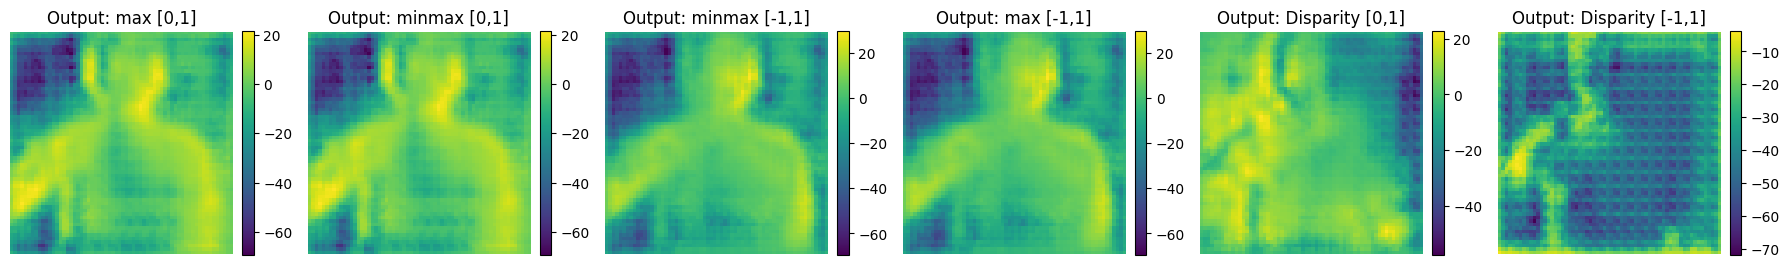

In [17]:
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt

# Set model to evaluation mode
model.eval()

# Paths to data and output folders
data_folder = "data/03"
output_folder = "data/output_masks"
os.makedirs(output_folder, exist_ok=True)

# Get all PNG files in the data folder
png_files = [f for f in os.listdir(data_folder) if f.endswith(".png")]

if len(png_files) == 0:
    print("No PNG files found in the folder.")
else:
    # Read the first PNG file
    file_name = png_files[0]
    file_path = os.path.join(data_folder, file_name)
    depth_map = cv2.imread(file_path, cv2.IMREAD_UNCHANGED)

    if depth_map is None:
        print(f"Unable to load image: {file_path}")
    else:
        print(f"Processing image: {file_name}, Original shape: {depth_map.shape}")

        # Resize the depth map to 128x128
        height, width = depth_map.shape
        print(f"Image shape: {depth_map.shape}")
        x_shift = width - 440
        cropped_depth_map = depth_map[:, x_shift:x_shift+360]
        
        depth_map_resized = cv2.resize(cropped_depth_map, (128, 128), interpolation=cv2.INTER_LINEAR)


        # 1. Normalize by max to [0, 1]
        norm_max_0_1 = depth_map_resized / np.max(depth_map_resized)
        input_max_0_1 = torch.tensor(norm_max_0_1, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

        # 2. Min-max normalize to [0, 1]
        norm_minmax_0_1 = (depth_map_resized - np.min(depth_map_resized)) / (np.max(depth_map_resized) - np.min(depth_map_resized))
        input_minmax_0_1 = torch.tensor(norm_minmax_0_1, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

        # 3. Min-max normalize to [-1, 1]
        norm_minmax_m1_1 = 2 * norm_minmax_0_1 - 1
        input_minmax_m1_1 = torch.tensor(norm_minmax_m1_1, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

        # 4. Normalize by max to [-1, 1]
        norm_max_m1_1 = 2 * (depth_map_resized / np.max(depth_map_resized)) - 1
        input_max_m1_1 = torch.tensor(norm_max_m1_1, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

        # 5. Disparity normalize to [0, 1]
        disparity_map = 1.0 / (depth_map_resized + 1e-6)
        norm_disp_0_1 = (disparity_map - np.min(disparity_map)) / (np.max(disparity_map) - np.min(disparity_map))
        input_disp_0_1 = torch.tensor(norm_disp_0_1, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

        # 6. Disparity normalize to [-1, 1]
        norm_disp_m1_1 = 2 * norm_disp_0_1 - 1
        input_disp_m1_1 = torch.tensor(norm_disp_m1_1, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

        # Pass each normalized input through the model and collect outputs
        with torch.no_grad():
            out_max_0_1 = model(input_max_0_1).squeeze().numpy()
            out_minmax_0_1 = model(input_minmax_0_1).squeeze().numpy()
            out_minmax_m1_1 = model(input_minmax_m1_1).squeeze().numpy()
            out_max_m1_1 = model(input_max_m1_1).squeeze().numpy()
            out_disp_0_1 = model(input_disp_0_1).squeeze().numpy()
            out_disp_m1_1 = model(input_disp_m1_1).squeeze().numpy()

        # Plot only the outputs
        plt.figure(figsize=(18, 4))
        plt.subplot(1, 6, 1)
        plt.title("Output: max [0,1]")
        plt.imshow(out_max_0_1, cmap="viridis")
        plt.colorbar(fraction=0.046, pad=0.04)
        plt.axis("off")

        plt.subplot(1, 6, 2)
        plt.title("Output: minmax [0,1]")
        plt.imshow(out_minmax_0_1, cmap="viridis")
        plt.colorbar(fraction=0.046, pad=0.04)
        plt.axis("off")

        plt.subplot(1, 6, 3)
        plt.title("Output: minmax [-1,1]")
        plt.imshow(out_minmax_m1_1, cmap="viridis")
        plt.colorbar(fraction=0.046, pad=0.04)
        plt.axis("off")

        plt.subplot(1, 6, 4)
        plt.title("Output: max [-1,1]")
        plt.imshow(out_max_m1_1, cmap="viridis")
        plt.colorbar(fraction=0.046, pad=0.04)
        plt.axis("off")

        plt.subplot(1, 6, 5)
        plt.title("Output: Disparity [0,1]")
        plt.imshow(out_disp_0_1, cmap="viridis")
        plt.colorbar(fraction=0.046, pad=0.04)
        plt.axis("off")

        plt.subplot(1, 6, 6)
        plt.title("Output: Disparity [-1,1]")
        plt.imshow(out_disp_m1_1, cmap="viridis")
        plt.colorbar(fraction=0.046, pad=0.04)
        plt.axis("off")

        plt.tight_layout()
        plt.show()

Image shape: (360, 640)
Processing image: depth_frame_0000.png, Image shape: (128, 128)
Input shape: torch.Size([1, 1, 128, 128])
Initial convolution output shape: torch.Size([1, 64, 32, 32])
Downsampling block 1 output shape: torch.Size([1, 64, 32, 32])
Downsampling block 2 output shape: torch.Size([1, 128, 16, 16])
Upsampling block 1 output shape: torch.Size([1, 128, 32, 32])
Upsampling block 2 output shape: torch.Size([1, 64, 64, 64])
Final upsampling output shape: torch.Size([1, 64, 64, 64])
Final convolution output shape: torch.Size([1, 1, 64, 64])
Total inference time: 0.0134 seconds


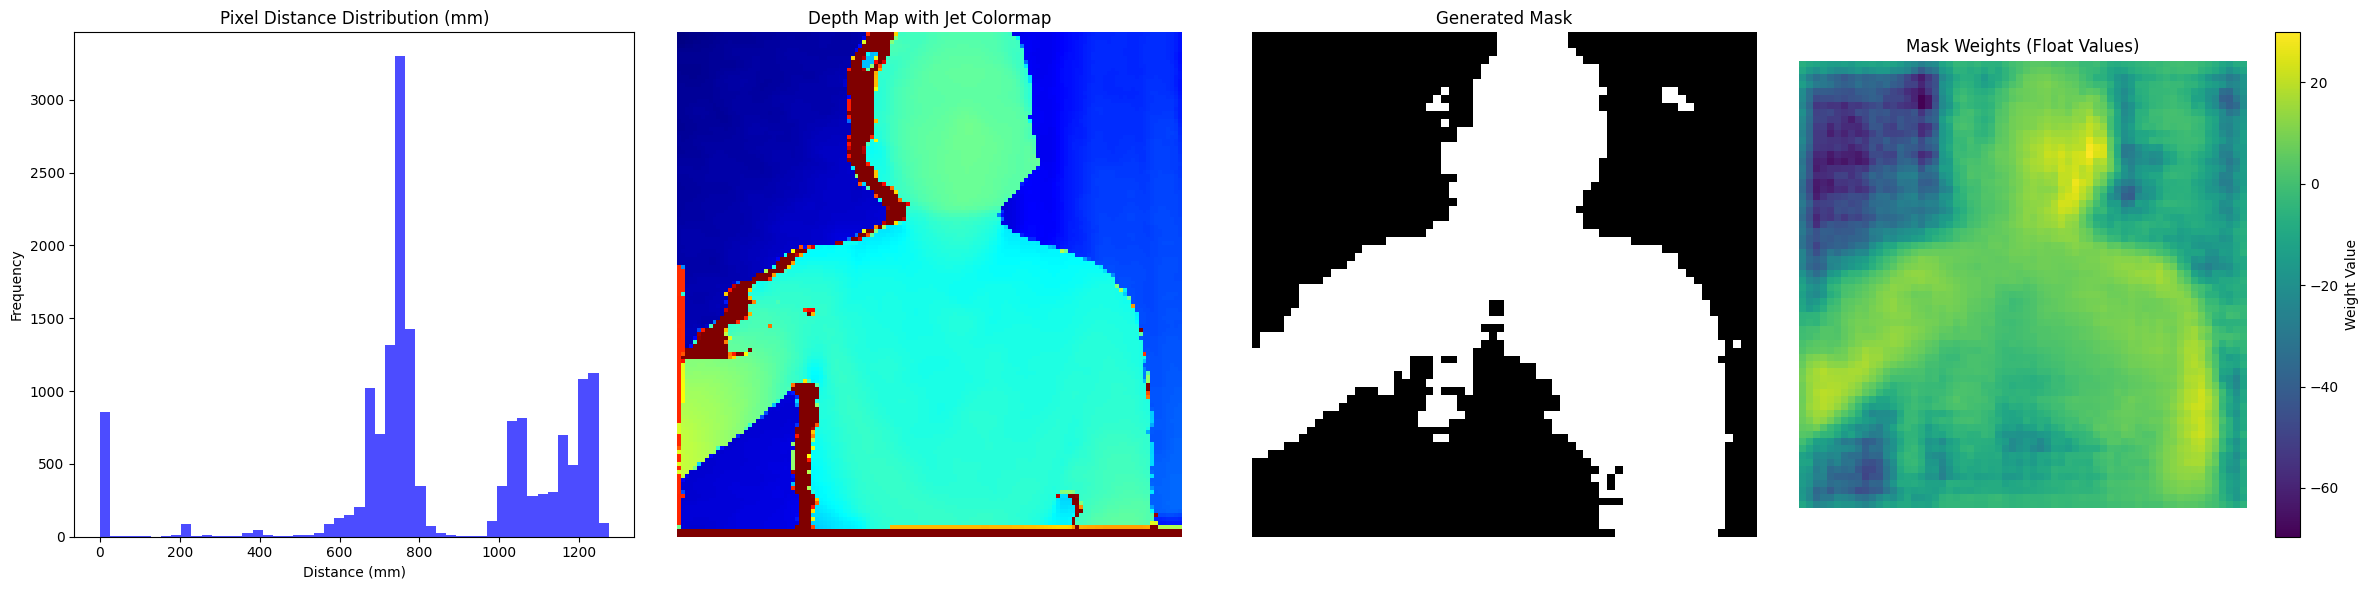

Image shape: (360, 640)
Processing image: depth_frame_0200.png, Image shape: (128, 128)
Input shape: torch.Size([1, 1, 128, 128])
Initial convolution output shape: torch.Size([1, 64, 32, 32])
Downsampling block 1 output shape: torch.Size([1, 64, 32, 32])
Downsampling block 2 output shape: torch.Size([1, 128, 16, 16])
Upsampling block 1 output shape: torch.Size([1, 128, 32, 32])
Upsampling block 2 output shape: torch.Size([1, 64, 64, 64])
Final upsampling output shape: torch.Size([1, 64, 64, 64])
Final convolution output shape: torch.Size([1, 1, 64, 64])
Total inference time: 0.0145 seconds


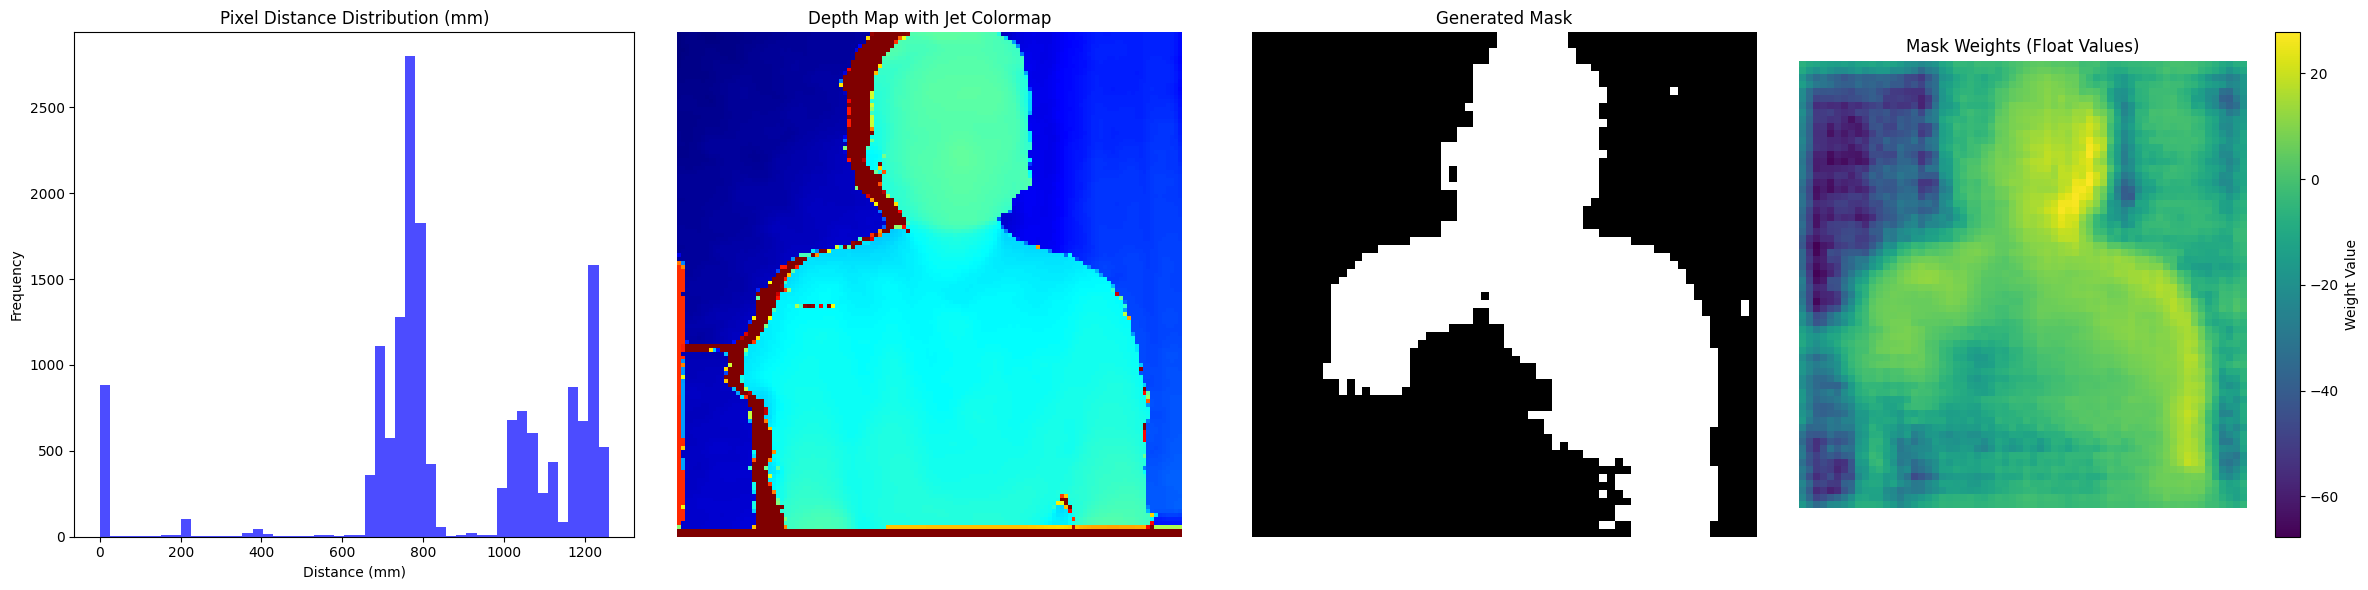

Image shape: (360, 640)
Processing image: depth_frame_0500.png, Image shape: (128, 128)
Input shape: torch.Size([1, 1, 128, 128])
Initial convolution output shape: torch.Size([1, 64, 32, 32])
Downsampling block 1 output shape: torch.Size([1, 64, 32, 32])
Downsampling block 2 output shape: torch.Size([1, 128, 16, 16])
Upsampling block 1 output shape: torch.Size([1, 128, 32, 32])
Upsampling block 2 output shape: torch.Size([1, 64, 64, 64])
Final upsampling output shape: torch.Size([1, 64, 64, 64])
Final convolution output shape: torch.Size([1, 1, 64, 64])
Total inference time: 0.0168 seconds


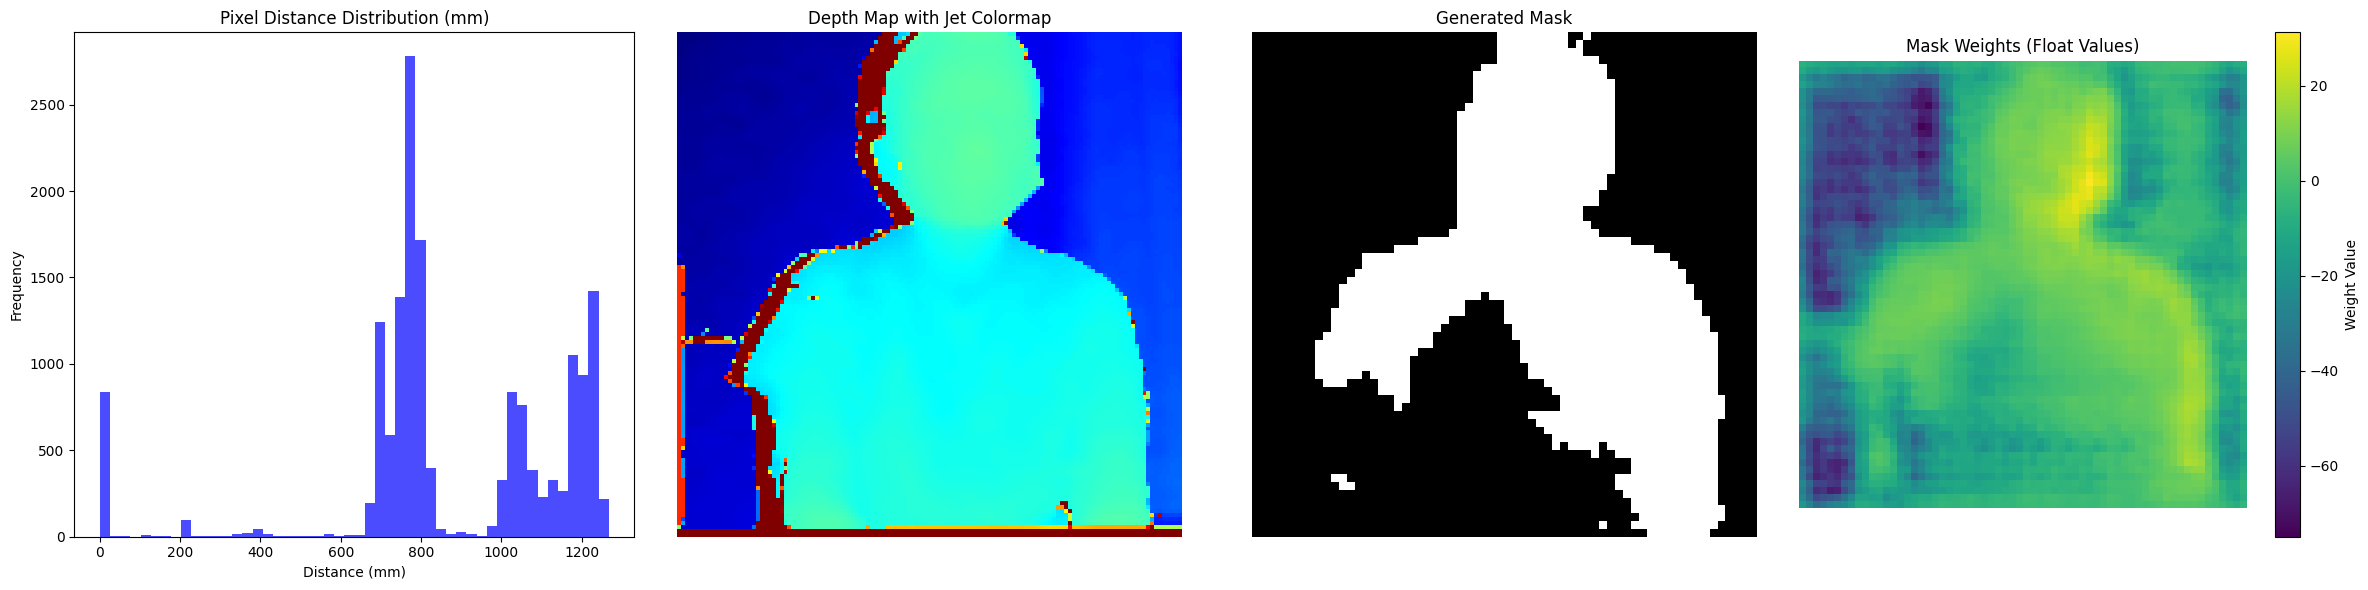

Image shape: (360, 640)
Processing image: depth_frame_0900.png, Image shape: (128, 128)
Input shape: torch.Size([1, 1, 128, 128])
Initial convolution output shape: torch.Size([1, 64, 32, 32])
Downsampling block 1 output shape: torch.Size([1, 64, 32, 32])
Downsampling block 2 output shape: torch.Size([1, 128, 16, 16])
Upsampling block 1 output shape: torch.Size([1, 128, 32, 32])
Upsampling block 2 output shape: torch.Size([1, 64, 64, 64])
Final upsampling output shape: torch.Size([1, 64, 64, 64])
Final convolution output shape: torch.Size([1, 1, 64, 64])
Total inference time: 0.0125 seconds


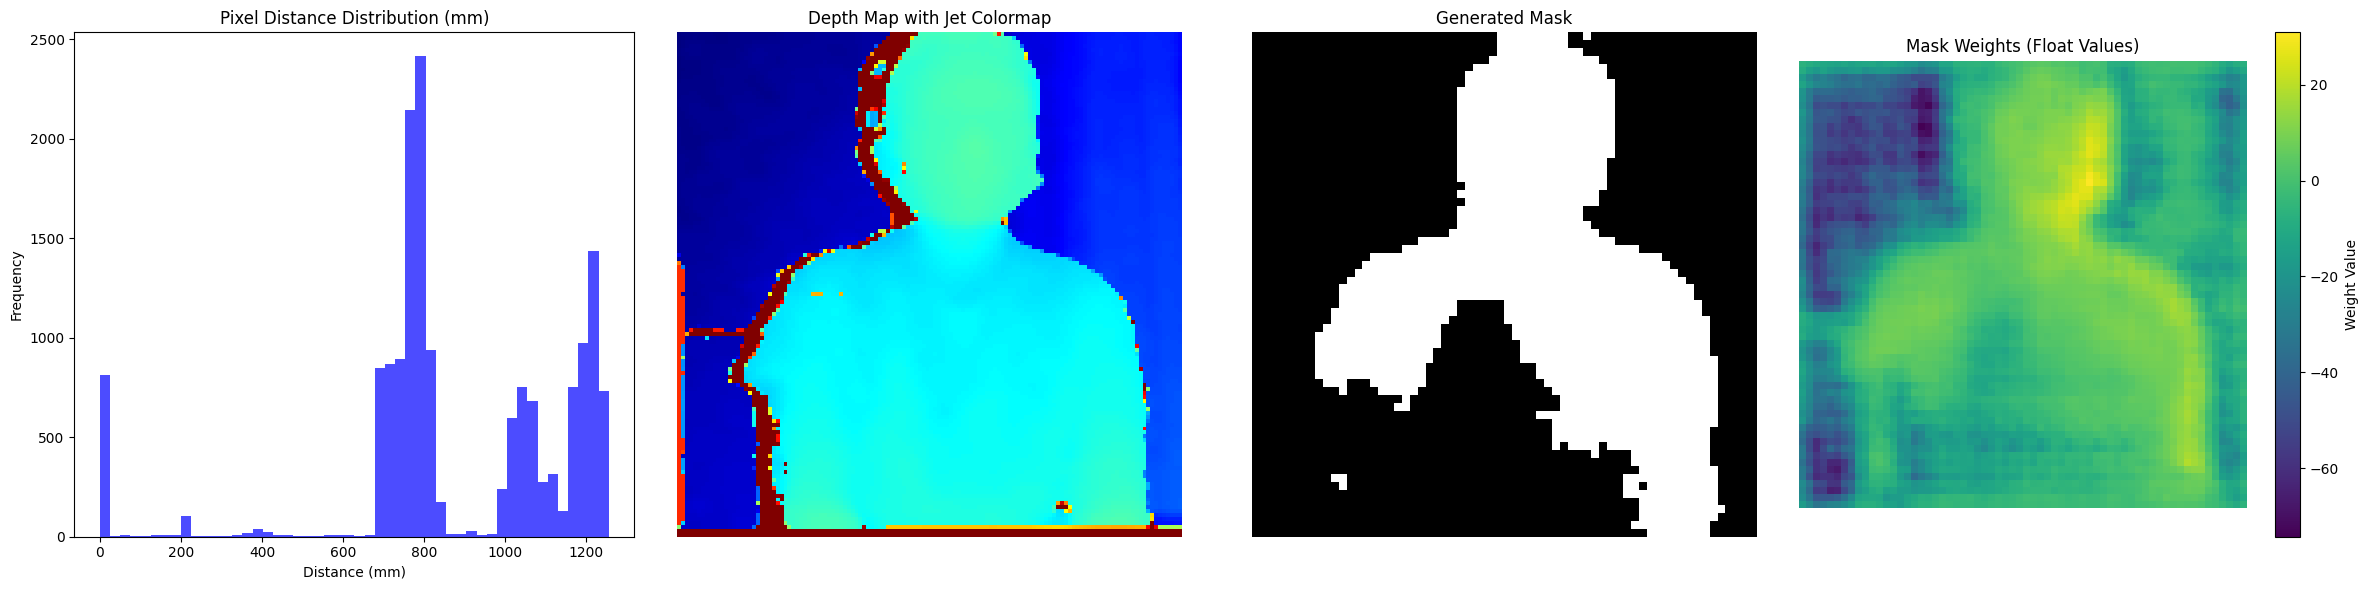

In [18]:
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt

# Load the model
model.eval()  # Set the model to evaluation mode

# Paths to data and output folders
data_folder = "data/03"
output_folder = "data/output_masks"
os.makedirs(output_folder, exist_ok=True)  # Create the output folder if it doesn't exist

# Get all PNG files in the data folder
png_files = [f for f in os.listdir(data_folder) if f.endswith(".png")]

# Process each PNG file
for file_name in png_files:
    file_path = os.path.join(data_folder, file_name)
    depth_map = cv2.imread(file_path, cv2.IMREAD_UNCHANGED)  # Load as a grayscale image (single channel)

    if depth_map is None:
        print(f"Unable to load image: {file_path}")
        continue

    height, width = depth_map.shape
    print(f"Image shape: {depth_map.shape}")
    x_shift = width - 440
    cropped_depth_map = depth_map[:, x_shift:x_shift+360]
    
    depth_map = cv2.resize(cropped_depth_map, (128, 128), interpolation=cv2.INTER_LINEAR)

    print(f"Processing image: {file_name}, Image shape: {depth_map.shape}")

    # Normalize the depth map to [0, 1]
    # normalized_depth_map = depth_map / np.max(depth_map)
    # Normalize the depth map to [-1, 1]
    normalized_depth_map = 2 * (depth_map - np.min(depth_map)) / (np.max(depth_map) - np.min(depth_map)) - 1
    
    input_tensor = torch.tensor(normalized_depth_map, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

    # Pass the tensor through the model
    with torch.no_grad():  # Disable gradient computation
        output = model(input_tensor)
        output_np = output.squeeze().numpy()

    # Binarize the output to create a mask (values 0 or 1)
    threshold = 0.0  # Set the threshold
    binary_mask = (output_np > threshold).astype(np.uint8)  # Values greater than the threshold are set to 1, others to 0

    # Convert the binary mask to an image format
    output_image = (binary_mask * 255).astype(np.uint8)  # Convert 0 and 1 to 0 and 255

    # Save the mask image
    output_file_path = os.path.join(output_folder, f"mask_{file_name}")
    cv2.imwrite(output_file_path, output_image)

    # Visualize the depth map using a jet colormap
    depth_colored = cv2.applyColorMap(cv2.convertScaleAbs(depth_map, alpha=255 / np.max(depth_map)), cv2.COLORMAP_JET)

    # Visualize the original depth map, mask, and pixel distribution
    plt.figure(figsize=(24, 6))

    # Subplot 1: Pixel distance distribution
    plt.subplot(1, 4, 1)
    plt.title("Pixel Distance Distribution (mm)")
    plt.hist(depth_map.flatten(), bins=50, color='blue', alpha=0.7)
    plt.xlabel("Distance (mm)")
    plt.ylabel("Frequency")

    # Subplot 2: Depth map with jet colormap
    plt.subplot(1, 4, 2)
    plt.title("Depth Map with Jet Colormap")
    plt.imshow(depth_colored)
    plt.axis("off")

    # Subplot 3: Generated mask
    plt.subplot(1, 4, 3)
    plt.title("Generated Mask")
    plt.imshow(output_image, cmap="gray")
    plt.axis("off")

    # Subplot 4: Mask weights (float values)
    plt.subplot(1, 4, 4)
    plt.title("Mask Weights (Float Values)")
    plt.imshow(output_np, cmap="viridis")  # Use Viridis colormap to display float weights
    plt.colorbar(label="Weight Value")
    plt.axis("off")

    plt.tight_layout()
    plt.show()